In [7]:
import math
import sys

sys.path.append('../../')

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import basinhopping

# from porousmedialab.metrics import rmse
# from porousmedialab.calibrator import find_indexes_of_intersections
from porousmedialab.column import Column
# from porousmedialab import blackbox as bb
from thawmeasurements import Vh2, Vh3, C2h, C3h, C3D33, C2D33, C3D21, C2D21, C3D9, C2D9, Tm_nz, C1h_nz, F3Tm, F3T_frz, T3Tm, T2T_thw, F2Tm, F2T_frz, T1T_thw, T2Tm, F1T_frz, T1Tm, C1h, T1C1h, F1C1h, T2C1h, F2C1h, T3C1h, F3C1h, C1D9, T1C1D9, T2C1D9, T3C1D9, C1D21, T1C1D21, F1C1D21, T2C1D21, F2C1D21, T3C1D21, F3C1D21, C1D33, T1C1D33, F1C1D33, T2C1D33, F2C1D33, T3C1D33, F3C1D33, Tm, T1Tm, F1Tm, T2Tm, F2Tm, T3Tm, F3Tm, zm, D_SF6w, D_SF6g, Kh, phi_m, z_phi, Vh1, SA, D_column, Vi, Ci, T1Ci, F1Ci, T2Ci, F2Ci, T3Ci, F3Ci, Ti, T1Ti, F1Ti, T2Ti, F2Ti, T3Ti, F3Ti, SF6_Hcc, T_frz, T_thw

In [8]:

dx = 0.2    ## cm
L = 40    ## cm
x = np.linspace(0, L, L / dx + 1)
phi = (0.99 - 0.91) * np.exp(-x / 10) + 0.91

Tm = np.concatenate([
    0 + T1Tm, F1T_frz + F1Tm, T1T_thw + T2Tm, F2T_frz + F2Tm, T2T_thw + T3Tm,
    F3T_frz + F3Tm
])
Ti = np.array(np.array([16, 177, 350, 514, 681, 851]))
t_shift = Ti[0]
Tm = Tm - t_shift
Ti_1 = Ti - t_shift

periods = np.concatenate([T_frz, T_thw])
periods.sort()
periods = periods - t_shift

dT = Tm_nz[1::2] - Tm_nz[::2]
dC1h = (C1h[1::2] - C1h[::2])
dC2h = (C2h[1::2] - C2h[::2])
dC3h = (C3h[1::2] - C3h[::2])
Fx_mean = (dC3h * Vh3 / SA / 2 + dC2h * Vh2 / SA / 2 + dC1h * Vh1 / SA / 2) / 3

CD33_mean = (C1D33 + C2D33 + C3D33) / 3
CD21_mean = (C1D21 + C2D21 + C3D21) / 3
CD9_mean = (C1D9 + C2D9 + C3D9) / 3

Mi = T1Ci * Vi    # mass injected
h_inj = Vi / SA / 0.93
phi_w = phi * (0.875 / 0.97)
phi_g = phi * ((0.97 - 0.875) / 0.97)
phi_p = 1 - phi

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [9]:
# k0 = [-0.00849195774801, 0.0806992844278, 0.0183607215331, 0.560548340486, 134.021803143, 0.0777450814787, 0.0150458649825, 0.568864576264, 112.174488887, 0.0694891885653, 0.00780601156074, 0.540289595896, 122.950029713]
# k0 = [-0.00867279213617, 0.0800476287551, 0.0191053231332, 0.561701007845, 117.444250572, 0.077231073886, 0.0151769835937, 0.569820541367, 111.577743478, 0.0726358179842, 0.00750182348686, 0.515291049662, 125.199441921]
# k0 = [-0.00878113722317, 0.0796385160858, 0.0189563583674, 0.568542220999, 127.432488765, 0.0770014055669, 0.0145710873752, 0.576223054311, 114.318866066, 0.0704866889262, 0.00752096252325, 0.537502201661, 122.932878363] #8.45
# k0= [-0.00903146931341, 0.0782060507081, 0.019635743291, 0.600865026075, 114.714196164, 0.0769491995886, 0.0155504786101, 0.552234433298, 110.057372223, 0.0700671348662, 0.00770841073105, 0.500305251789, 121.799508569] #8.28
# k0 = [-0.0101290681196, 0.0740826188505, 0.0231223292687, 0.659227928082, 42.8420944607, 0.0778617924345, 0.0151646229094, 0.549950824173, 98.4142088668, 0.0632072252829, 0.00764995965286, 0.434681131391, 125.051600208]
# k0 = [-0.00967992935174, 
#       0.0742807154204, 0.0225191598404, 0.652601999048, 49.0130808599, 
#       0.0770344722979, 0.0151464119572, 0.562712707943, 96.4395831887, 
#       0.0624565480289, 0.00799773687605, 0.440438143185, 125.130125]
k0 = [-0.01, 
      0.07, 0.023, 0.4, 90, 
      0.07, 0.015, 0.4, 90, 
      0.07, 0.008, 0.4, 90]

In [10]:
w, k_w_in_1, k_w_out_1, k_g_in_1, k_g_out_1, k_w_in_2, k_w_out_2, k_g_in_2, k_g_out_2, k_w_in_3, k_w_out_3, k_g_in_3, k_g_out_3 = k0

In [11]:
tend = periods[0]
# tend = 457
dt = 0.01
dx = 0.2    ## cm
L = 40    ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape)    #
Fx = np.zeros(t.shape)
phi = (0.99 - 0.91) * np.exp(-x / 10) + 0.91

ftc1 = Column(L, dx, tend, dt)

ftc1.add_species(
    theta=phi_g/(1-np.log(phi)),
    name='SF6g',
    D=D_SF6g,
    init_C=0,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=-0.00)    #-0.055
ftc1.add_species(
    theta=phi_w/(1-np.log(phi)),
    name='SF6w',
    D=D_SF6w,
    init_C=0,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc1.add_species(
    theta=phi_p,
    name='SF6mp',
    D=1e-18,
    init_C=0,
    bc_top=0,
    bc_top_type='flux',
    bc_bot=0,
    bc_bot_type='flux')

# # Constants
ftc1.constants['k_w_in'] = k_w_in_1    #from FTR w
ftc1.constants['k_w_out'] = k_w_out_1
#0.4

ftc1.constants['k_g_in'] = k_g_in_1
ftc1.constants['k_g_out'] = k_g_out_1

ftc1.constants['phi_w'] = phi_w
ftc1.constants['phi_g'] = phi_g
ftc1.constants['phi_p'] = phi_p

# # Rates of diffusion into pores and out
ftc1.rates['R_w_in'] = 'k_w_in * SF6w'
ftc1.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc1.rates['R_w_in'] = '0'
# ftc1.rates['R_w_out'] = '0'

ftc1.rates['R_g_in'] = 'k_g_in * SF6w'
ftc1.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc1.dcdt[
    'SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc1.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc1.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'

Fx = np.zeros(t.size)

for i in range(0, len(ftc1.time)):
    if (ftc1.time[i] > periods[0] and ftc1.time[i] < periods[1]) or (
            ftc1.time[i] > periods[2] and ftc1.time[i] < periods[3]
    ) or (ftc1.time[i] > periods[4] and ftc1.time[i] < periods[5]):
        ftc1.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        ftc1.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        Fx[i] = 0
    else:
        ftc1.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        ftc1.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        F1 = ftc1.estimate_flux_at_top('SF6g', i)
        F2 = ftc1.estimate_flux_at_top('SF6w', i)
        F3 = ftc1.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i] + F2[i] + F3[i]
    if any([ftc1.time[i] == T_inj for T_inj in Ti_1]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_1 == ftc1.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc1.profiles['SF6w'] + SF6_add    #
        ftc1.change_concentration_profile('SF6w', i, new_profile)

    ftc1.integrate_one_timestep(i)

Ti_2 = Ti - periods[0]
tend = periods[2] - periods[0]
dt = 0.01
dx = 0.2    ## cm
L = 40    ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape)    #
Fx = np.zeros(t.shape)
phi = (0.99 - 0.91) * np.exp(-x / 10) + 0.91

ftc2 = Column(L, dx, tend, dt)

ftc2.add_species(
    theta=phi_g/(1-np.log(phi)),
    name='SF6g',
    D=D_SF6g,
    init_C=ftc1.profiles.SF6g,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=-0.00)    #-0.055
ftc2.add_species(
    theta=phi_g/(1-np.log(phi)),
    name='SF6w',
    D=D_SF6w,
    init_C=ftc1.profiles.SF6w,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc2.add_species(
    theta=phi_p,
    name='SF6mp',
    D=1e-18,
    init_C=ftc1.profiles.SF6mp,
    bc_top=0,
    bc_top_type='flux',
    bc_bot=0,
    bc_bot_type='flux')

# # Constants
ftc2.constants['k_w_in'] = k_w_in_2    #from FTR w
ftc2.constants['k_w_out'] = k_w_out_2
#0.4

ftc2.constants['k_g_in'] = k_g_in_2
ftc2.constants['k_g_out'] = k_g_out_2

ftc2.constants['phi_w'] = phi_w
ftc2.constants['phi_g'] = phi_g
ftc2.constants['phi_p'] = phi_p

# # Rates of diffusion into pores and out
ftc2.rates['R_w_in'] = 'k_w_in * SF6w'
ftc2.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc2.rates['R_w_in'] = '0'
# ftc2.rates['R_w_out'] = '0'

ftc2.rates['R_g_in'] = 'k_g_in * SF6w'
ftc2.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc2.dcdt[
    'SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc2.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc2.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'

for i in range(0, len(ftc2.time)):
    if (ftc2.time[i] + periods[0] > periods[0]
            and ftc2.time[i] + periods[0] < periods[1]) or (
                ftc2.time[i] + periods[0] > periods[2]
                and ftc2.time[i] + periods[0] < periods[3]) or (
                    ftc2.time[i] + periods[0] > periods[4]
                    and ftc2.time[i] + periods[0] < periods[5]):
        ftc2.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        ftc2.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        Fx[i] = 0
    else:
        ftc2.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        ftc2.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        F1 = ftc2.estimate_flux_at_top('SF6g', i)
        F2 = ftc2.estimate_flux_at_top('SF6w', i)
        F3 = ftc2.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i] + F2[i] + F3[i]
    if any([ftc2.time[i] == T_inj for T_inj in Ti_2]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_2 == ftc2.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc2.profiles['SF6w'] + SF6_add    #
        ftc2.change_concentration_profile('SF6w', i, new_profile)

    ftc2.integrate_one_timestep(i)


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Boundary conditions changed for SF6g at time 0.01
Boundary conditions changed for SF6w at time 0.01
Boundary conditions changed for SF6g at time 192.0
Boundary conditions changed for SF6w at time 192.0


In [36]:
periods

array([114, 306, 457, 596, 796, 944])

In [59]:

Ti_3 = Ti - periods[2]
tend = periods[4] - periods[2]
dt = 0.01
dx = 0.2    ## cm
L = 40    ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape)    #
Fx = np.zeros(t.shape)
phi = (0.99 - 0.91) * np.exp(-x / 10) + 0.91

ftc3 = Column(L, dx, tend, dt)

ftc3.add_species(
    theta=phi_g/(1-np.log(phi)),
    name='SF6g',
    D=D_SF6g,
    init_C=ftc2.profiles.SF6g,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=-0.00)    #-0.055
ftc3.add_species(
    theta=phi_w/(1-np.log(phi)),
    name='SF6w',
    D=D_SF6w,
    init_C=ftc2.profiles.SF6w,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc3.add_species(
    theta=phi_p,
    name='SF6mp',
    D=1e-18,
    init_C=ftc2.profiles.SF6mp,
    bc_top=0,
    bc_top_type='flux',
    bc_bot=0,
    bc_bot_type='flux')

# # Constants
ftc3.constants['k_w_in'] = k_w_in_3    #from FTR w
ftc3.constants['k_w_out'] = k_w_out_3
#0.4

ftc3.constants['k_g_in'] = k_g_in_3
ftc3.constants['k_g_out'] = k_g_out_3

ftc3.constants['phi_w'] = phi_w
ftc3.constants['phi_g'] = phi_g
ftc3.constants['phi_p'] = phi_p

# # Rates of diffusion into pores and out
ftc3.rates['R_w_in'] = 'k_w_in * SF6w'
ftc3.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc3.rates['R_w_in'] = '0'
# ftc3.rates['R_w_out'] = '0'

ftc3.rates['R_g_in'] = 'k_g_in * SF6w'
ftc3.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc3.dcdt[
    'SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc3.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc3.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'

for i in range(0, len(ftc3.time)):
    if (ftc3.time[i] + periods[2] > periods[0]
            and ftc3.time[i] + periods[2] < periods[1]) or (
                ftc3.time[i] + periods[2] > periods[2]
                and ftc3.time[i] + periods[2] < periods[3]) or (
                    ftc3.time[i] + periods[2] > periods[4]
                    and ftc3.time[i] + periods[2] < periods[5]):
        ftc3.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        ftc3.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        Fx[i] = 0
    else:
        ftc3.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        ftc3.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        F1 = ftc3.estimate_flux_at_top('SF6g', i)
        F2 = ftc3.estimate_flux_at_top('SF6w', i)
        F3 = ftc3.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i] + F2[i] + F3[i]
    if any([ftc3.time[i] == T_inj for T_inj in Ti_3]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_3 == ftc3.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc3.profiles['SF6w'] + SF6_add    #
        ftc3.change_concentration_profile('SF6w', i, new_profile)

    ftc3.integrate_one_timestep(i)

# idxs_c_1 = find_indexes_of_intersections(ftc1.time, Tm)
# idxs_c_2 = find_indexes_of_intersections(ftc2.time + ftc1.time[-1], Tm)
# idxs_c_3 = find_indexes_of_intersections(
#     ftc3.time + ftc2.time[-1] + ftc1.time[-1], Tm)

# idxs_f_1 = find_indexes_of_intersections(ftc1.time, Tm[::2]+1)
# idxs_f_2 = find_indexes_of_intersections(ftc2.time + ftc1.time[-1], Tm[::2]+1)
# idxs_f_3 = find_indexes_of_intersections(ftc3.time + ftc2.time[-1] + ftc1.time[-1, Tm[::2]+1)


/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Boundary conditions changed for SF6g at time 0.01
Boundary conditions changed for SF6w at time 0.01
Boundary conditions changed for SF6g at time 139.0
Boundary conditions changed for SF6w at time 139.0


In [61]:
%%timeit
Ti_3 = Ti - periods[2]
tend = periods[4] - periods[2]
dt = 0.01
dx = 0.2    ## cm
L = 40    ## cm
x = np.linspace(0, L, L / dx + 1)
t = np.linspace(0, tend, round(tend / dt) + 1)
#phi = 0.8
Chs = np.zeros(t.shape)    #
Fx = np.zeros(t.shape)
phi = (0.99 - 0.91) * np.exp(-x / 10) + 0.91

ftc3 = Column(L, dx, tend, dt)

ftc3.add_species(
    theta=phi_g/(1-np.log(phi)),
    name='SF6g',
    D=D_SF6g,
    init_C=ftc2.profiles.SF6g,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=-0.00)    #-0.055
ftc3.add_species(
    theta=phi_w/(1-np.log(phi)),
    name='SF6w',
    D=D_SF6w,
    init_C=ftc2.profiles.SF6w,
    bc_top=0,
    bc_top_type='constant',
    bc_bot=0,
    bc_bot_type='constant',
    w=w)

# SF6mp stands for SF6 gas in micro pores, it is immobile and only collects SF6;
ftc3.add_species(
    theta=phi_p,
    name='SF6mp',
    D=1e-18,
    init_C=ftc2.profiles.SF6mp,
    bc_top=0,
    bc_top_type='flux',
    bc_bot=0,
    bc_bot_type='flux')

# # Constants
ftc3.constants['k_w_in'] = k_w_in_3    #from FTR w
ftc3.constants['k_w_out'] = k_w_out_3
#0.4

ftc3.constants['k_g_in'] = k_g_in_3
ftc3.constants['k_g_out'] = k_g_out_3

ftc3.constants['phi_w'] = phi_w
ftc3.constants['phi_g'] = phi_g
ftc3.constants['phi_p'] = phi_p

# # Rates of diffusion into pores and out
ftc3.rates['R_w_in'] = 'k_w_in * SF6w'
ftc3.rates['R_w_out'] = 'k_w_out * SF6mp'
# ftc3.rates['R_w_in'] = '0'
# ftc3.rates['R_w_out'] = '0'

ftc3.rates['R_g_in'] = 'k_g_in * SF6w'
ftc3.rates['R_g_out'] = 'k_g_out * SF6g'

# # dcdt
ftc3.dcdt[
    'SF6w'] = '-R_g_in + R_g_out * phi_g - R_w_in + R_w_out * phi_p'
ftc3.dcdt['SF6g'] = 'R_g_in / phi_g - R_g_out'
ftc3.dcdt['SF6mp'] = 'R_w_in / phi_p - R_w_out'

for i in range(0, len(ftc3.time)):
    if (ftc3.time[i] + periods[2] > periods[0]
            and ftc3.time[i] + periods[2] < periods[1]) or (
                ftc3.time[i] + periods[2] > periods[2]
                and ftc3.time[i] + periods[2] < periods[3]) or (
                    ftc3.time[i] + periods[2] > periods[4]
                    and ftc3.time[i] + periods[2] < periods[5]):
        ftc3.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        ftc3.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
        Fx[i] = 0
    else:
        ftc3.change_boundary_conditions(
            'SF6g', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        ftc3.change_boundary_conditions(
            'SF6w', i, bc_top=0, bc_top_type='constant', bc_bot=0, bc_bot_type='flux')
        F1 = ftc3.estimate_flux_at_top('SF6g', i)
        F2 = ftc3.estimate_flux_at_top('SF6w', i)
        F3 = ftc3.estimate_flux_at_top('SF6mp', i)
        Fx[i] = F1[i] + F2[i] + F3[i]
    if any([ftc3.time[i] == T_inj for T_inj in Ti_3]):
        SF6_add = np.zeros(x.size)
        SF6_add[x > 0] = 0
        SF6_add[x > 18 - (h_inj / 2)] = Ci[Ti_3 == ftc3.time[i]]
        SF6_add[x > 18 + (h_inj / 2)] = 0
        new_profile = ftc3.profiles['SF6w'] + SF6_add    #
        ftc3.change_concentration_profile('SF6w', i, new_profile)

    ftc3.integrate_one_timestep(i)

# idxs_c_1 = find_indexes_of_intersections(ftc1.time, Tm)
# idxs_c_2 = find_indexes_of_intersections(ftc2.time + ftc1.time[-1], Tm)
# idxs_c_3 = find_indexes_of_intersections(
#     ftc3.time + ftc2.time[-1] + ftc1.time[-1], Tm)

# idxs_f_1 = find_indexes_of_intersections(ftc1.time, Tm[::2]+1)
# idxs_f_2 = find_indexes_of_intersections(ftc2.time + ftc1.time[-1], Tm[::2]+1)
# idxs_f_3 = find_indexes_of_intersections(ftc3.time + ftc2.time[-1] + ftc1.time[-1, Tm[::2]+1)



/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Boundary conditions changed for SF6g at time 0.01
Boundary conditions changed for SF6w at time 0.01
Boundary conditions changed for SF6g at time 139.0
Boundary conditions changed for SF6w at time 139.0
Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Boundary conditions changed for SF6g at time 0.01
Boundary conditions changed for SF6w at time 0.01
Boundary conditions changed for SF6g at time 139.0
Boundary conditions changed for SF6w at time 139.0
Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Boundary conditions changed for SF6g at time 0.01
Boundary conditions changed for SF6w at time 0.01
Boundary conditions changed for SF6g at time 139.0
Boundary conditions changed for SF6w at time 139.0
Boundary conditions changed for SF6g at time 0.0
Boundary conditions changed for SF6w at time 0.0
Bo

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
                                                                                                                                                                                                                    
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 32})
sns.set_context("poster", rc={"font.size":34,"axes.titlesize":34,"axes.labelsize":34, "lines.linewidth": 4, 'lines.markersize':10})  
plt.rcParams['figure.figsize'] = 8, 6


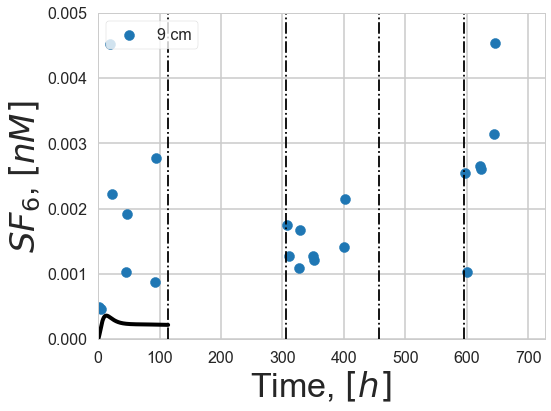

In [40]:
zm = 9
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C3D9)/2, label='9 cm')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')


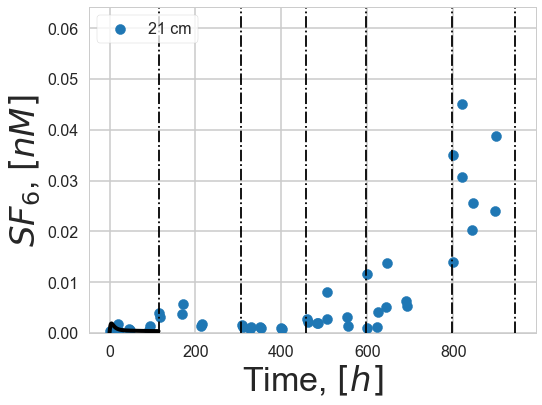

In [41]:
zm = 21
# plt.scatter(Tm, C1D21, label ='21 cm (C1)')
# plt.scatter(Tm, C2D21, label ='21 cm (C2)')
# plt.scatter(Tm, C3D21, label ='21 cm (C3)')
plt.scatter(Tm, (C1D21+C3D21)/2, label='21 cm')
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1)
# plt.xlim(0,)
plt.ylim(0,)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')

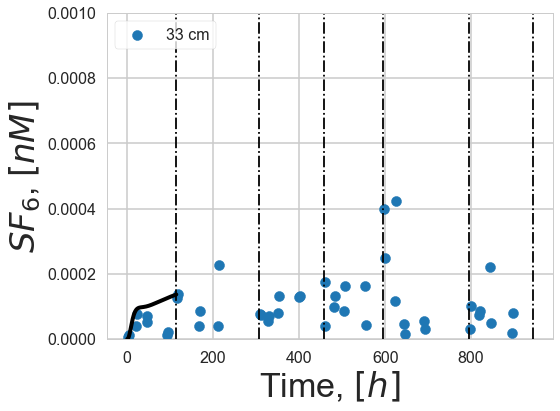

In [62]:
zm = 33
measured = (ftc1.SF6w.concentration[ftc1.x == zm, :][0] * phi_w[ftc1.x == zm] + ftc1.SF6g.concentration[ftc1.x == zm, :][0] * phi_g[ftc1.x == zm] ) / (phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])
# plt.scatter(Tm, C1D33, label='33 cm (C1)')
# plt.scatter(Tm, C2D33, label='33 cm (C2)')
# plt.scatter(Tm, C3D33, label='33 cm (C3)')
plt.scatter(Tm, (C1D33+C3D33)/2, label='33 cm')
plt.plot(ftc1.time, measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1, loc=2)
# plt.xlim(0,800)
plt.ylim(0, 0.001)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')

(0, 800)

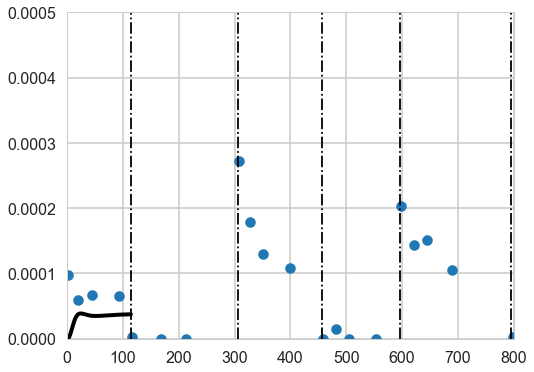

In [43]:
F1 = ftc1.estimate_flux_at_top('SF6g')
F2 = ftc1.estimate_flux_at_top('SF6w')
F3 = ftc1.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc1.time, F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
# dC2h = (C2h[1::2] - C2h[::2])
dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], (dC1h*Vh1/SA/2 + dC3h*Vh3/SA/2)/2)
# plt.scatter(Tm_1, dC2h*Vh2/SA/2)
# plt.scatter(Tm_1, dC3h*Vh3/SA/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)



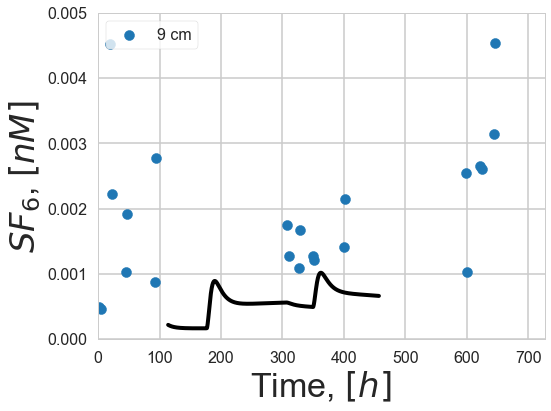

In [44]:
zm = 9
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C3D9)/2, label='9 cm')
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)




(0, 0.064206189379445694)

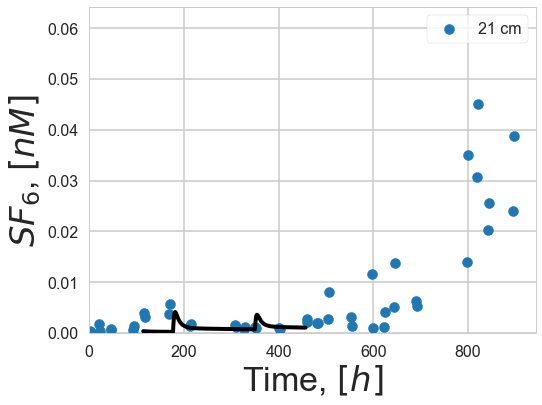

In [45]:
zm = 21
# plt.scatter(Tm, C1D21, label ='21 cm (C1)')
# plt.scatter(Tm, C2D21, label ='21 cm (C2)')
# plt.scatter(Tm, C3D21, label ='21 cm (C3)')
plt.scatter(Tm, (C1D21+C3D21)/2, label='21 cm')
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1)
plt.xlim(0,)
plt.ylim(0,)

(0, 0.001)

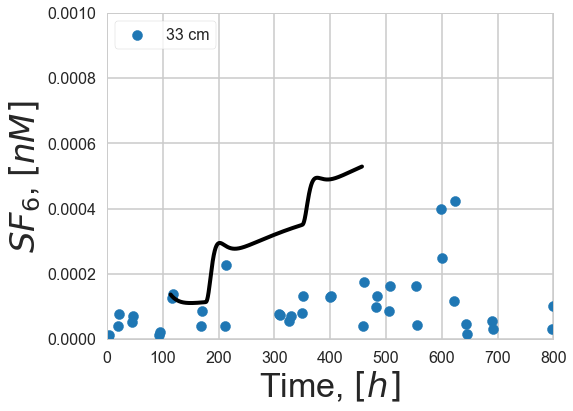

In [46]:
zm = 33
measured = (ftc2.SF6w.concentration[ftc2.x == zm, :][0] * phi_w[ftc2.x == zm] + ftc2.SF6g.concentration[ftc2.x == zm, :][0] * phi_g[ftc2.x == zm] ) / (phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])
# plt.scatter(Tm, C1D33, label='33 cm (C1)')
# plt.scatter(Tm, C2D33, label='33 cm (C2)')
# plt.scatter(Tm, C3D33, label='33 cm (C3)')
plt.scatter(Tm, (C1D33+C3D33)/2, label='33 cm')
plt.plot(ftc2.time+periods[0], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.legend(frameon=1, loc=2)
plt.xlim(0,800)
plt.ylim(0, 0.001)

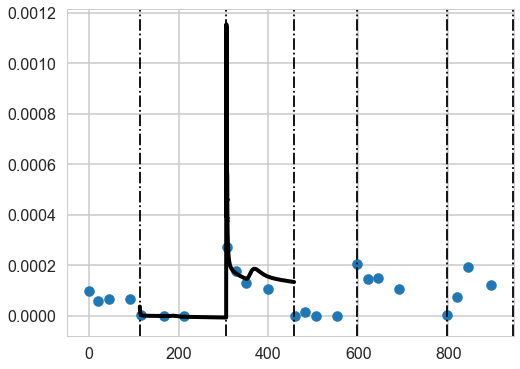

In [63]:
F1 = ftc2.estimate_flux_at_top('SF6g')
F2 = ftc2.estimate_flux_at_top('SF6w')
F3 = ftc2.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc2.time+periods[0], F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
# dC2h = (C2h[1::2] - C2h[::2])
dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], (dC3h*Vh3/SA/2+dC1h*Vh1/SA/2)/2)
# plt.scatter(Tm, dC2h*Vh2/SA/2)
# plt.scatter(Tm, dC3h*Vh3/SA/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
# plt.ylim(0,0.0005)
# plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)




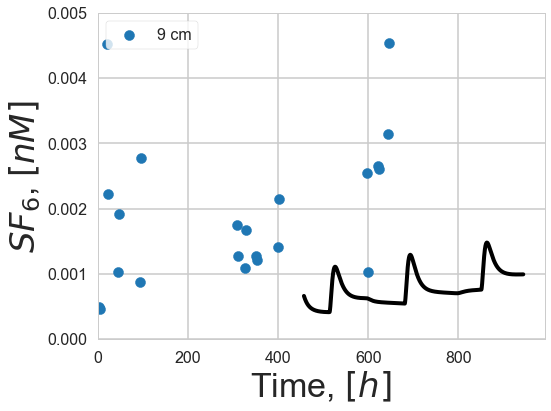

In [48]:
zm = 9
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D9+C3D9)/2, label='9 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)





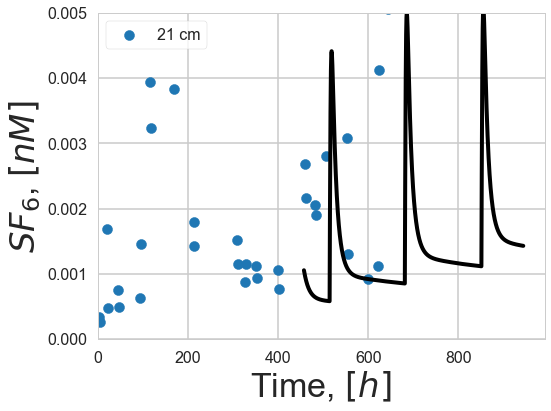

In [49]:
zm = 21
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D21+C3D21)/2, label='21 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)





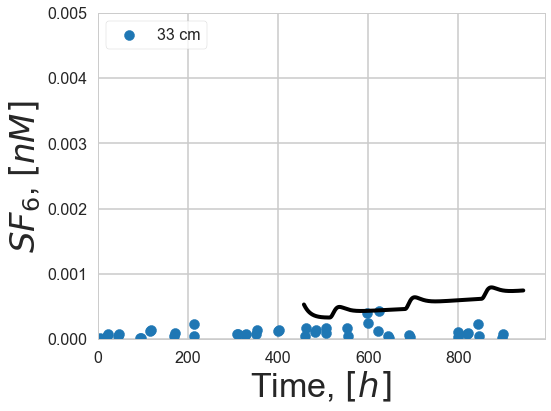

In [50]:
zm = 33
measured = (ftc3.SF6w.concentration[ftc3.x == zm, :][0] * phi_w[ftc3.x == zm] + ftc3.SF6g.concentration[ftc3.x == zm, :][0] * phi_g[ftc3.x == zm] ) / (phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])
# plt.scatter(Tm, C1D9, label='9 cm (C1)')
# plt.scatter(Tm, C2D9, label='9 cm (C2)')
# plt.scatter(Tm, C3D9, label='9 cm (C3)')
plt.scatter(Tm, (C1D33+C3D33)/2, label='33 cm')
plt.plot(ftc3.time+periods[2], measured, 'k-')
plt.ylabel(r'$SF_6$, $[nM]$')
plt.xlabel('Time, $[h]$')
plt.xlim(0,)
plt.ylim(0,0.005)
plt.legend(frameon=1, loc=2)






(0, 800)

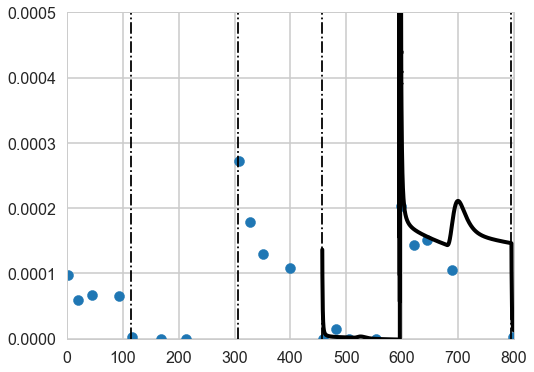

In [51]:
F1 = ftc3.estimate_flux_at_top('SF6g')
F2 = ftc3.estimate_flux_at_top('SF6w')
F3 = ftc3.estimate_flux_at_top('SF6mp')
# # gas flux

# plt.plot(ftc1.time, F1, 'g')
# plt.plot(ftc1.time, F2, 'b')
plt.plot(ftc3.time+periods[2], F1+F2+F3, 'k')
# plt.plot(T_frz, [0] )
# F2 = ftc.estimate_flux_at_top('SF6w') # dissolved gas flux
# plt.plot(ftc.time, F2)


dC1h = (C1h[1::2] - C1h[::2])
dC3h = (C3h[1::2] - C3h[::2])

# plt.scatter(Tm[::2], dC1h*Vh1/SA/2)
# plt.scatter(Tm[::2], dC3h*Vh3/SA/2)
plt.scatter(Tm[::2], (dC3h*Vh3/SA/2 + dC1h*Vh1/SA/2)/2)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
plt.xlim(0,800)
# plt.scatter((Tm[::2]+1), dC1h*Vh1/SA/dT)





In [52]:
MF1 = ftc1.estimate_flux_at_top('SF6g') + ftc1.estimate_flux_at_top('SF6w') + ftc1.estimate_flux_at_top('SF6mp')
MF2 = ftc2.estimate_flux_at_top('SF6g') + ftc2.estimate_flux_at_top('SF6w') + ftc2.estimate_flux_at_top('SF6mp')
MF3 = ftc3.estimate_flux_at_top('SF6g') + ftc3.estimate_flux_at_top('SF6w') + ftc3.estimate_flux_at_top('SF6mp')

MF = np.concatenate((MF1, MF2, MF3))

MT = np.concatenate((ftc1.time, ftc2.time + ftc1.time[-1], ftc3.time + ftc2.time[-1] + ftc1.time[-1]))

(0, 0.0005)

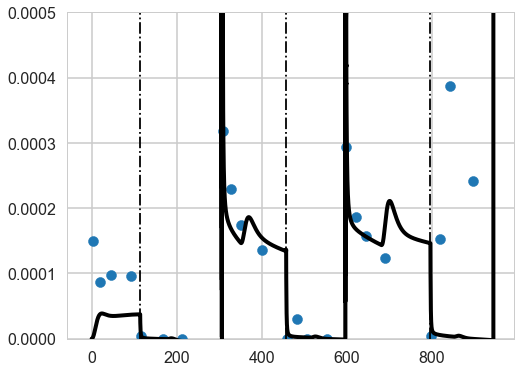

In [58]:

plt.plot(MT, MF, 'k')


dC1h = (C1h[1::2] - C1h[::2])
dC3h = (C3h[1::2] - C3h[::2])

plt.scatter(Tm[::2], dC3h*Vh3/SA/2)

for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')
plt.ylim(0,0.0005)
# plt.xlim(0,800)






In [54]:

zm = 9
M1D9 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D9 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D9 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD9 = np.concatenate((M1D9[0], M2D9[0], M3D9[0]))

zm = 21
M1D21 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D21 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D21 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD21 = np.concatenate((M1D21[0], M2D21[0], M3D21[0]))

zm = 33
M1D33 = (
    ftc1.SF6w.concentration[ftc1.x == zm, :] *
    phi_w[ftc1.x == zm] + ftc1.SF6g.
    concentration[ftc1.x == zm, :] * phi_g[ftc1.x == zm]) / (
        phi_w[ftc1.x == zm] + phi_g[ftc1.x == zm])

M2D33 = (
    ftc2.SF6w.concentration[ftc2.x == zm, :] *
    phi_w[ftc2.x == zm] + ftc2.SF6g.
    concentration[ftc2.x == zm, :] * phi_g[ftc2.x == zm]) / (
        phi_w[ftc2.x == zm] + phi_g[ftc2.x == zm])

M3D33 = (
    ftc3.SF6w.concentration[ftc3.x == zm, :] *
    phi_w[ftc3.x == zm] + ftc3.SF6g.
    concentration[ftc3.x == zm, :] * phi_g[ftc3.x == zm]) / (
        phi_w[ftc3.x == zm] + phi_g[ftc3.x == zm])

MD33 = np.concatenate((M1D33[0], M2D33[0], M3D33[0]))


MF1 = ftc1.estimate_flux_at_top('SF6g') + ftc1.estimate_flux_at_top('SF6w') + ftc1.estimate_flux_at_top('SF6mp')
MF2 = ftc2.estimate_flux_at_top('SF6g') + ftc2.estimate_flux_at_top('SF6w') + ftc2.estimate_flux_at_top('SF6mp')
MF3 = ftc3.estimate_flux_at_top('SF6g') + ftc3.estimate_flux_at_top('SF6w') + ftc3.estimate_flux_at_top('SF6mp')

MF = np.concatenate((MF1, MF2, MF3))

MT = np.concatenate((ftc1.time, ftc2.time + ftc1.time[-1], ftc3.time + ftc2.time[-1] + ftc1.time[-1]))



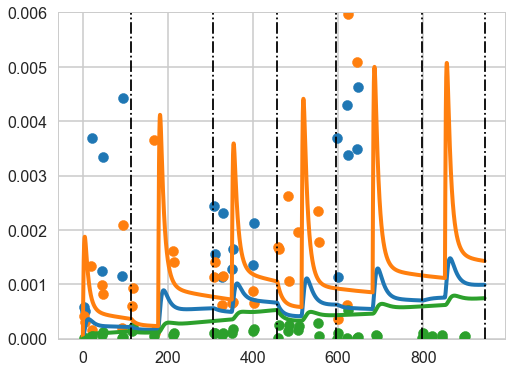

In [55]:
plt.plot(MT, MD9)
plt.scatter(Tm, C3D9)
plt.plot(MT, MD21)
plt.scatter(Tm, C3D21)
plt.plot(MT, MD33)
plt.scatter(Tm, C3D33)
# plt.xlim(0,796)
plt.ylim(0,0.006)
for xc in periods:
    plt.axvline(x=xc, color='k', linewidth=1.8, linestyle='-.')

In [56]:
np.savetxt("results.csv", np.array([MT, MF, MD9, MD21, MD33]).T, delimiter=",")

In [57]:
MT

array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.43980000e+02,   9.43990000e+02,   9.44000000e+02])